과제 : 패션 데이터 지도 학습 시키기


In [1]:
from sklearn.datasets import fetch_openml
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

1. 데이터 준비

In [2]:
# 1. Load Data
mnist = fetch_openml('mnist_784', as_frame=True, parser='auto')

In [3]:
mnist.data.head(), mnist.target.head()

(   pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0       0       0       0       0       0       0       0       0       0   
 1       0       0       0       0       0       0       0       0       0   
 2       0       0       0       0       0       0       0       0       0   
 3       0       0       0       0       0       0       0       0       0   
 4       0       0       0       0       0       0       0       0       0   
 
    pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
 0        0  ...         0         0         0         0         0         0   
 1        0  ...         0         0         0         0         0         0   
 2        0  ...         0         0         0         0         0         0   
 3        0  ...         0         0         0         0         0         0   
 4        0  ...         0         0         0         0         0         0   
 
    pixel781  pixel782  pixel783  pixel784  
 0 

In [4]:
# 1-3. Split
target = mnist.target.astype(int).to_frame()
feature = mnist.data
print(target.shape, feature.shape)
print(type(target), type(feature))
print(target.nunique())

(70000, 1) (70000, 784)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
class    10
dtype: int64


2. Create DataSet

In [5]:
# 2-1. Define Dataset class
class fashion_dataset(Dataset):
    def __init__(self, x_data, y_data):  # 초기화 함수
        super().__init__()
        x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data  
        y_data = y_data.values if isinstance(y_data, pd.DataFrame) else y_data
        
        # ndarray ==> Tensor
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data)

    def __len__(self):  # 갯수 확인 콜백 함수
        return self.target.shape[0]

    def __getitem__(self, index):   # 특정 인덱스 데이터+라벨 반환 콜백 함수
        return self.feature[index], self.target[index]

In [6]:
# 2-2. Set my_dataset
my_dataset = fashion_dataset(feature, target)
# my_dataset[0], feature.iloc[0], target.iloc[0]

In [7]:
# 2-3. Split train, validate, test
from torch.utils.data import random_split

seed = torch.Generator().manual_seed(11)

train_ds, val_ds, test_ds = random_split(my_dataset, [0.7, 0.1, 0.2], generator=seed)
print(f"[train, val, test] {len(train_ds), len(val_ds), len(test_ds)}")

[train, val, test] (49000, 7000, 14000)


3. Create DataLoader

In [8]:
# 3. Create dataLoader
batch = 32
train_dl = DataLoader(train_ds, batch_size=batch)
val_dl = DataLoader(val_ds, batch_size=batch)
test_dl = DataLoader(test_ds, batch_size=batch)
len(train_dl), len(val_dl), len(test_dl)

(1532, 219, 438)

4. Define Model Class

In [9]:
# 4. define class
class ClassiModel(nn.Module):
    def __init__(self, in_dim, out_dim):
        in_to_hidden = 100
        hidden_to_out = 50
        super(ClassiModel, self).__init__()
        self.input_layer = nn.Linear(in_dim, in_to_hidden)
        self.relu = nn.ReLU()
        self.hidden_layer = nn.Linear(in_to_hidden, hidden_to_out)
        self.output_layer = nn.Linear(hidden_to_out, out_dim)

    def forward(self, x):
        y = self.input_layer(x)
        y = self.relu(y)
        y = self.hidden_layer(y)
        y = self.relu(y)
        y = self.output_layer(y)
        return y

5. Prepare Training

In [10]:
# 1) Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# 2) Train count
Epoch = 50
# 3) Model instance
IN, OUT = my_dataset.feature.shape[1], len(torch.unique(my_dataset.target))
# print(IN, OUT)
model = ClassiModel(IN, OUT).to(DEVICE)

# 4) loss func.
LOSS_FUNC = nn.CrossEntropyLoss().to(DEVICE)

# 5) Optimize instance
import torch.optim as optim

OPTIMIZER = optim.Adam(model.parameters(), lr=0.01)

# 6) Scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode="min", patience=10)

6. Define Train / Validate functions

In [11]:
import torchmetrics.functional as metrics

In [12]:
target.shape, target.squeeze().shape

((70000, 1), (70000,))

6-1. Train Function

In [13]:
def training(PRINT=False):
    model.train()
    train_loss, train_acc = [], []
    for cnt, (data, target) in enumerate(train_dl):
        data, target = data.to(DEVICE), target.to(DEVICE)   # Set to DEVICE
        target = target.squeeze()   # (70000,1) -> (70000,)
        
        pre_target = model(data)    # Prediction from feature
        
        loss = LOSS_FUNC(pre_target, target)    # Calculate loss function
        train_loss.append(loss)
        
        OPTIMIZER.zero_grad()   # Reset W, b
        loss.backward()         # Proceed backward to loss values
        OPTIMIZER.step()        # Update W, b
        
        acc = metrics.accuracy(pre_target, target, task="multiclass", num_classes=OUT)
        # print(acc)
        train_acc.append(acc)
    
    mean_train_loss = sum(train_loss)/len(train_loss)
    
    if PRINT:
        print(f'[ Total Run : {cnt+1} ]')
        print(f'Mean train loss : {mean_train_loss}, final acc : {sum(train_acc)/len(train_acc)}')

    return mean_train_loss

training(PRINT=True)  # for testing

[ Total Run : 1532 ]
Mean train loss : 0.7915234565734863, final acc : 0.8317966461181641


tensor(0.7915, grad_fn=<DivBackward0>)

6-2. Validate Function

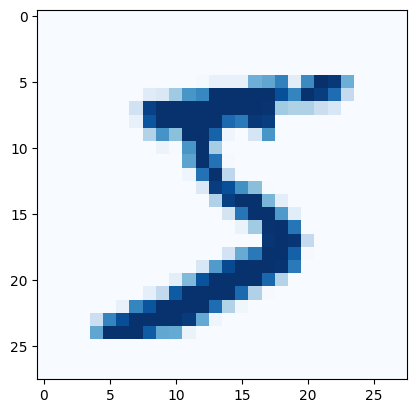

In [14]:
import matplotlib.pyplot as plt

# feature[0] 이미지화
plt.imshow(feature.iloc[0].values.reshape(28,28), cmap='Blues')


In [15]:
# 